In [1]:
import os, csv, time, math
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

DATA_DIR = "dataset_large"
OUT_CSV  = "solution_ipm_qp.csv"

# ===== IPM params =====
MAX_ITERS = 80
PRINT_EVERY = 1

# Practical stopping (tránh singular khi mu quá nhỏ)
STOP_EQ   = 1e-9
STOP_IN   = 1e-9
STOP_DUAL = 1e-7

# Step-to-boundary
ALPHA_FRACTION = 0.995

# KKT regularization (chống singular)
REG_H = 1e-10
REG_A = 1e-12

# Numerical floors
MIN_POS = 1e-18

# Clamp tiny x for nicer output
CLAMP_X_EPS = 1e-9


In [2]:
def load_edges(data_dir: str):
    wh = list(csv.DictReader(open(os.path.join(data_dir, "warehouses.csv"), encoding="utf-8")))
    cu = list(csv.DictReader(open(os.path.join(data_dir, "customers.csv"),  encoding="utf-8")))

    wh_ids = sorted(int(r["id"]) for r in wh)
    cu_ids = sorted(int(r["id"]) for r in cu)

    wh_row = {int(r["id"]): r for r in wh}
    cu_row = {int(r["id"]): r for r in cu}

    S = np.array([float(wh_row[i]["supply"]) for i in wh_ids], dtype=float)
    D = np.array([float(cu_row[j]["demand"]) for j in cu_ids], dtype=float)

    w2i = {wid: k for k, wid in enumerate(wh_ids)}
    c2j = {cid: k for k, cid in enumerate(cu_ids)}

    edges = []
    with open(os.path.join(data_dir, "cost_params.csv"), encoding="utf-8") as f:
        rd = csv.DictReader(f)
        for r in rd:
            i = w2i[int(r["i"])]
            j = c2j[int(r["j"])]
            a = float(r["a_ij"])
            b = float(r["b_ij"])
            if a < 0:
                raise ValueError(f"Need convex: a_ij >= 0. Found a={a} for (i={r['i']}, j={r['j']})")
            edges.append((i, j, a, b))

    if S.sum() + 1e-12 < D.sum():
        raise ValueError("Infeasible: total supply < total demand")

    return wh_ids, cu_ids, S, D, edges


def build_qp_matrices(S, D, edges, m, n, E):
    a_arr = np.array([a for (i, j, a, b) in edges], dtype=float)
    b_arr = np.array([b for (i, j, a, b) in edges], dtype=float)

    # QP form: 0.5 x^T P x + q^T x  with Pdiag=2a, q=b
    P = sp.diags(2.0 * a_arr, format="csc")
    q = b_arr.copy()

    i_idx = np.array([i for (i, j, a, b) in edges], dtype=int)
    j_idx = np.array([j for (i, j, a, b) in edges], dtype=int)
    e_idx = np.arange(E, dtype=int)

    # A demand: n x E
    A = sp.csc_matrix((np.ones(E), (j_idx, e_idx)), shape=(n, E))

    # supply: m x E
    Asup = sp.csc_matrix((np.ones(E), (i_idx, e_idx)), shape=(m, E))

    # G = [Asup; -I], h=[S; 0]
    G = sp.vstack([Asup, -sp.eye(E, format="csc")], format="csc")
    h = np.concatenate([S, np.zeros(E, dtype=float)])
    b = D.copy()

    return P, q, A, b, G, h, a_arr, b_arr


In [3]:
def inf_norm(x):
    return float(np.max(np.abs(x))) if x.size else 0.0

def pos_part_max(x):
    return float(np.max(np.maximum(0.0, x))) if x.size else 0.0

def step_to_boundary(v, dv, fraction=ALPHA_FRACTION):
    idx = dv < 0
    if not np.any(idx):
        return 1.0
    alpha = float(np.min(-v[idx] / dv[idx]))
    return min(1.0, fraction * alpha)

def make_v(s, z, r_pri_in, r_cent):
    return (-r_cent + z * r_pri_in) / s

def solve_kkt(P, A, G, s, z, r_dual, r_pri_eq, r_pri_in, r_cent):
    w = z / s
    W = sp.diags(w, format="csc")
    H = P + (G.T @ (W @ G))

    # regularize H
    if REG_H > 0:
        H = H + REG_H * sp.eye(H.shape[0], format="csc")

    v = make_v(s, z, r_pri_in, r_cent)
    rhs1 = -r_dual - (G.T @ v)

    # regularize 0-block with -REG_A I
    if REG_A > 0:
        Zb = -REG_A * sp.eye(A.shape[0], format="csc")
    else:
        Zb = sp.csc_matrix((A.shape[0], A.shape[0]))

    K = sp.bmat([[H, A.T],
                 [A, Zb]], format="csc")

    rhs = np.concatenate([rhs1, -r_pri_eq])

    sol = spla.spsolve(K, rhs)
    dx = sol[:H.shape[0]]
    dy = sol[H.shape[0]:]

    ds = -r_pri_in - (G @ dx)
    dz = (-r_cent - z * ds) / s

    return dx, dy, ds, dz


In [4]:
t_start = time.perf_counter()

wh_ids, cu_ids, S, D, edges = load_edges(DATA_DIR)
m, n, E = len(wh_ids), len(cu_ids), len(edges)

P, q, A, b, G, h, a_arr, b_arr = build_qp_matrices(S, D, edges, m, n, E)
p = G.shape[0]

# init
x = np.zeros(E, dtype=float)
y = np.zeros(n, dtype=float)

gx = G @ x
s = (h - gx) + 1.0
s = np.maximum(s, 1.0)
z = np.ones(p, dtype=float)

# history
hist = {
    "iter": [],
    "cost": [],
    "mu": [],
    "eq_inf": [],
    "in_pos": [],
    "dual_inf": [],
    "time": []
}

for it in range(1, MAX_ITERS + 1):
    r_dual   = (P @ x) + q + (A.T @ y) + (G.T @ z)
    r_pri_eq = (A @ x) - b
    r_pri_in = (G @ x) + s - h

    mu = float((s @ z) / p)

    cost = float(np.sum(a_arr * x * x + b_arr * x))
    eq_inf = inf_norm(r_pri_eq)
    in_pos = pos_part_max((G @ x) - h)
    dual_inf = inf_norm(r_dual)
    elapsed = time.perf_counter() - t_start

    hist["iter"].append(it)
    hist["cost"].append(cost)
    hist["mu"].append(mu)
    hist["eq_inf"].append(eq_inf)
    hist["in_pos"].append(in_pos)
    hist["dual_inf"].append(dual_inf)
    hist["time"].append(elapsed)

    if (it == 1) or (it % PRINT_EVERY == 0) or (it == MAX_ITERS):
        print(f"iter={it:3d}  cost={cost:,.6f}  mu={mu:.3e}  "
              f"eq_inf={eq_inf:.3e}  in_pos={in_pos:.3e}  dual_inf={dual_inf:.3e}  "
              f"t={elapsed:.3f}s")

    if eq_inf <= STOP_EQ and in_pos <= STOP_IN and dual_inf <= STOP_DUAL:
        print("[STOP] converged (practical)")
        break

    # Predictor
    r_cent_aff = s * z
    dx_aff, dy_aff, ds_aff, dz_aff = solve_kkt(P, A, G, s, z, r_dual, r_pri_eq, r_pri_in, r_cent_aff)

    alpha_aff_pri  = step_to_boundary(s, ds_aff)
    alpha_aff_dual = step_to_boundary(z, dz_aff)
    alpha_aff = min(alpha_aff_pri, alpha_aff_dual)

    s_aff = np.maximum(s + alpha_aff * ds_aff, MIN_POS)
    z_aff = np.maximum(z + alpha_aff * dz_aff, MIN_POS)

    mu_aff = float((s_aff @ z_aff) / p)
    sigma = (mu_aff / mu) ** 3 if mu > 0 else 0.0

    # Corrector
    r_cent = (s * z) + (ds_aff * dz_aff) - (sigma * mu) * np.ones(p)
    dx, dy, ds, dz = solve_kkt(P, A, G, s, z, r_dual, r_pri_eq, r_pri_in, r_cent)

    alpha_pri  = step_to_boundary(s, ds)
    alpha_dual = step_to_boundary(z, dz)
    alpha = min(alpha_pri, alpha_dual)

    if not np.isfinite(alpha) or alpha <= 0:
        raise RuntimeError(f"Non-positive step at iter={it}. alpha={alpha}")

    x = x + alpha * dx
    y = y + alpha * dy
    s = np.maximum(s + alpha * ds, MIN_POS)
    z = np.maximum(z + alpha * dz, MIN_POS)

# clamp x for nicer output
x = np.maximum(x, 0.0)
x[x < CLAMP_X_EPS] = 0.0

# final checks
dem = A @ x
supply = (G[:m, :] @ x)
max_dem_err = float(np.max(np.abs(dem - b)))
max_sup_excess = float(np.max(supply - S))
min_x = float(np.min(x))
final_cost = float(np.sum(a_arr * x * x + b_arr * x))

total_time = time.perf_counter() - t_start

print("\n=== FINAL (IPM QP) ===")
print(f"Cost Z = {final_cost:,.6f}")
print(f"MAX_SUPPLY_EXCESS = {max_sup_excess:.6e}")
print(f"MAX_DEMAND_ABS_ERR = {max_dem_err:.6e}")
print(f"MIN_X = {min_x:.6e}")
print(f"[TIME] Total solve time = {total_time:.6f} seconds")

# save in same order as cost_params.csv
in_path = os.path.join(DATA_DIR, "cost_params.csv")
out_path = OUT_CSV

with open(in_path, encoding="utf-8") as f_in, open(out_path, "w", newline="", encoding="utf-8") as f_out:
    rd = csv.DictReader(f_in)
    fieldnames = rd.fieldnames + ["x_ij"]
    wr = csv.DictWriter(f_out, fieldnames=fieldnames)
    wr.writeheader()
    for e, r in enumerate(rd):
        r["x_ij"] = f"{x[e]:.12f}"
        wr.writerow(r)

print(f"[SAVE] {out_path}")

# Load solution to dataframe for plotting
df_sol = pd.read_csv(out_path)
df_sol["x_ij"] = df_sol["x_ij"].astype(float)



iter=  1  cost=0.000000  mu=2.116e+00  eq_inf=4.999e+01  in_pos=0.000e+00  dual_inf=4.999e+01  t=0.050s
iter=  2  cost=-10,372.763301  mu=2.562e+00  eq_inf=4.983e+01  in_pos=9.918e-01  dual_inf=4.983e+01  t=1.120s
iter=  3  cost=-18,865.319949  mu=3.507e+00  eq_inf=4.949e+01  in_pos=9.865e-01  dual_inf=4.950e+01  t=2.829s
iter=  4  cost=-21,105.401851  mu=5.391e+00  eq_inf=4.864e+01  in_pos=9.720e-01  dual_inf=4.865e+01  t=4.467s
iter=  5  cost=-24,789.021403  mu=8.863e+00  eq_inf=4.613e+01  in_pos=9.221e-01  dual_inf=4.614e+01  t=5.518s
iter=  6  cost=-22,168.608668  mu=1.342e+01  eq_inf=3.857e+01  in_pos=7.708e-01  dual_inf=3.857e+01  t=6.522s
iter=  7  cost=-2,419.855536  mu=1.416e+01  eq_inf=2.503e+01  in_pos=4.971e-01  dual_inf=2.503e+01  t=7.339s
iter=  8  cost=12,525.911347  mu=1.341e+01  eq_inf=1.859e+01  in_pos=3.116e-01  dual_inf=1.859e+01  t=8.257s
iter=  9  cost=23,823.447529  mu=1.292e+01  eq_inf=1.435e+01  in_pos=2.840e-01  dual_inf=1.435e+01  t=9.158s
iter= 10  cost=27,9

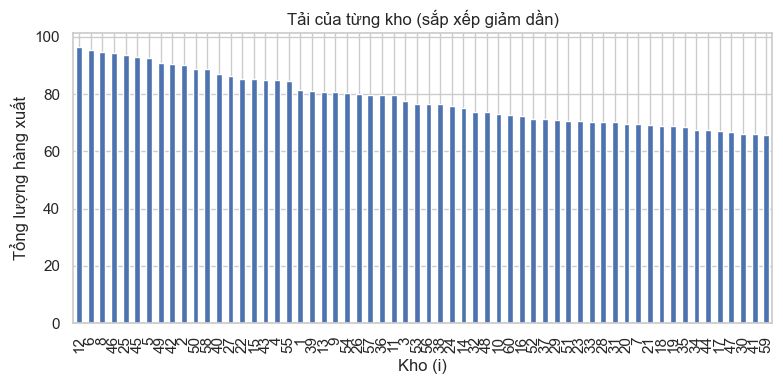

In [5]:
warehouse_load = (
    df_sol.groupby("i")["x_ij"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 4))
warehouse_load.plot(kind="bar")
plt.xlabel("Kho (i)")
plt.ylabel("Tổng lượng hàng xuất")
plt.title("Tải của từng kho (sắp xếp giảm dần)")
plt.tight_layout()
plt.show()


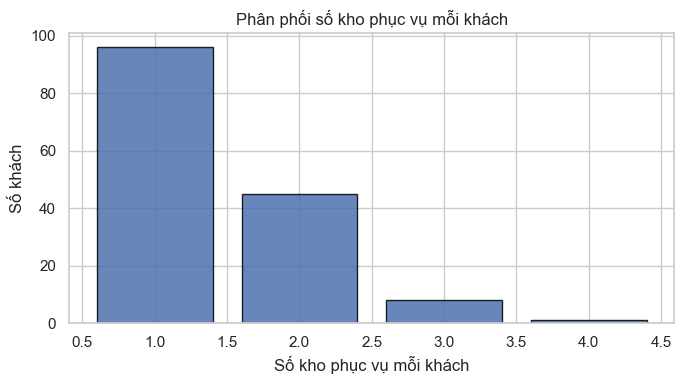

In [6]:
customer_sources = (
    df_sol[df_sol["x_ij"] > 1e-6]
    .groupby("j")
    .size()
)

counts = customer_sources.value_counts().sort_index()

plt.figure(figsize=(7, 4))
plt.bar(
    counts.index,
    counts.values,
    edgecolor="black",
    alpha=0.85
)
plt.xlabel("Số kho phục vụ mỗi khách")
plt.ylabel("Số khách")
plt.title("Phân phối số kho phục vụ mỗi khách")
plt.tight_layout()
plt.show()


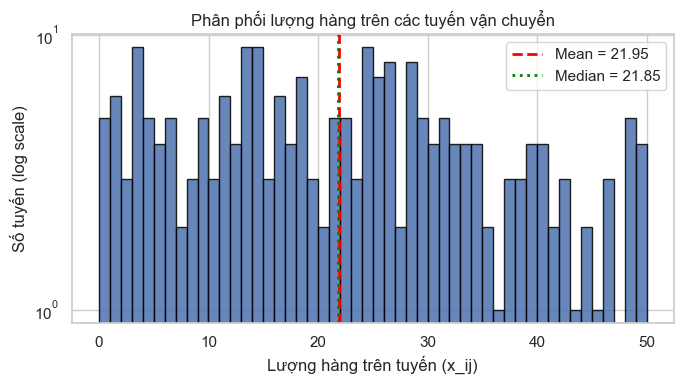

In [7]:
flows = df_sol["x_ij"][df_sol["x_ij"] > 1e-6]

mean_flow = flows.mean()
median_flow = flows.median()

plt.figure(figsize=(7, 4))
plt.hist(
    flows,
    bins=50,
    edgecolor="black",
    alpha=0.85
)
plt.yscale("log")

plt.axvline(mean_flow, color="red", linestyle="--", linewidth=2,
            label=f"Mean = {mean_flow:.2f}")
plt.axvline(median_flow, color="green", linestyle=":", linewidth=2,
            label=f"Median = {median_flow:.2f}")

plt.xlabel("Lượng hàng trên tuyến (x_ij)")
plt.ylabel("Số tuyến (log scale)")
plt.title("Phân phối lượng hàng trên các tuyến vận chuyển")
plt.legend()
plt.tight_layout()
plt.show()


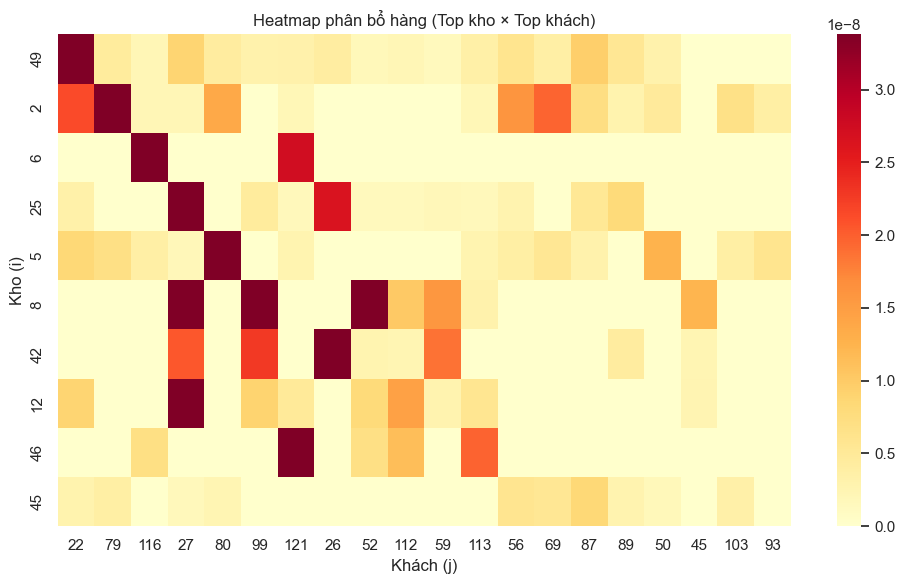

In [8]:
top_k_warehouses = 10
top_k_customers = 20

top_w = warehouse_load.head(top_k_warehouses).index

top_c = (
    df_sol.groupby("j")["x_ij"]
    .sum()
    .sort_values(ascending=False)
    .head(top_k_customers)
    .index
)

filtered = df_sol[
    df_sol["i"].isin(top_w) & df_sol["j"].isin(top_c)
]

pivot = filtered.pivot(index="i", columns="j", values="x_ij").fillna(0)

pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot = pivot[pivot.sum(axis=0).sort_values(ascending=False).index]

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    cmap="YlOrRd",
    vmax=np.percentile(pivot.values, 95)
)
plt.xlabel("Khách (j)")
plt.ylabel("Kho (i)")
plt.title("Heatmap phân bổ hàng (Top kho × Top khách)")
plt.tight_layout()
plt.show()


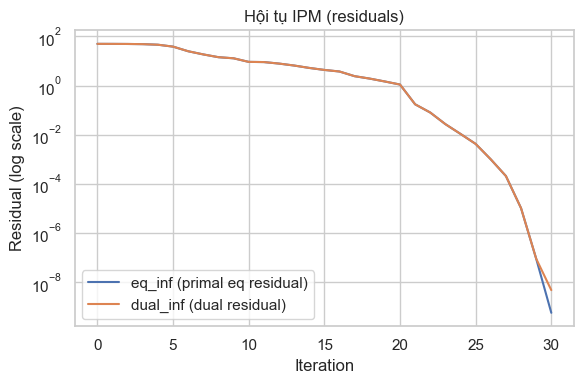

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(hist["eq_inf"], label="eq_inf (primal eq residual)")
plt.plot(hist["dual_inf"], label="dual_inf (dual residual)")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Residual (log scale)")
plt.legend()
plt.title("Hội tụ IPM (residuals)")
plt.tight_layout()
plt.show()
